# A Data-Driven Exploration of Global Demographic Trends from 1950 to 2050 #
### Arya Amarnath and Ronnie Delgado ##
### DSCI 235: Data Wrangling - Final Project
### Professor Asa Ben-Hur
### May 4, 2024

### [Github Repository](https://github.com/aamarnath1/235-Final-Project)
### [Kaggle Dataset](https://www.kaggle.com/datasets/census/international-data)


## Abstract

For our project, we decided to investigate the “International Datasets” dataset found on Kaggle that goes over the estimates of country populations from 1950 to 2017 with predictions through 2050. The data set includes midyear populations (age at the middle of the year) broken down by age and gender at birth. There is also data including fertility rates, birth rates, death rates, and migration rates. We are particularly interested in these features where we want to analyze fertility rates, mortality rates, population growth, and aging trends across various countries. The main goal of this project is to uncover insights or potential patterns on how these various human development indexes span across various countries across time. Below are some questions we currently aim to analyze:

- How do fertility rates vary across different age groups and countries/regions? 
   - What trends can be observed over time?
- How do mortality rates and life expectancy at birth vary across countries/regions?
- How have life expectancy trends changed globally, and what disparities exist between regions?
- What trends can be observed in population growth rates across different regions and how do they relate to birth and death rates?
- How do migration rates impact population growth in countries/regions?


## Importing Packages and Datasets ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams

In [2]:
fertility = pd.read_csv("data/age_specific_fertility_rates.csv")
births = pd.read_csv("data/birth_death_growth_rates.csv") 
country_area = pd.read_csv("data/country_names_area.csv")
midyear_pop_5yrs = pd.read_csv("data/midyear_population_5yr_age_sex.csv")
mortality_life = pd.read_csv("data/mortality_life_expectancy.csv")

## Data Cleaning and Wrangling ##

### Mortality, Birth + Fertility Datasets ###

In [3]:
mortality_life.drop(['mortality_rate_1to4', 'mortality_rate_1to4_male', 'mortality_rate_1to4_female'], axis=1, inplace=True)
fertility.drop('gross_reproduction_rate',axis=1, inplace=True)

pop_changes = pd.merge(fertility, births, on = ['country_code', 'country_name', 'year'], how = 'left')
pop_changes = pd.merge(pop_changes, mortality_life, on = ['country_code', 'country_name', 'year'], how = 'left')
pop_changes['fertility_rate_40+'] = pop_changes['fertility_rate_40_44'] + pop_changes['fertility_rate_45_49']
pop_changes['fertility_rate_20_to_40'] = pop_changes['fertility_rate_20_24'] + pop_changes['fertility_rate_25_29'] + pop_changes['fertility_rate_30_34'] + pop_changes['fertility_rate_35_39']
pop_changes['fertility_rate_Under_20'] = pop_changes['fertility_rate_15_19']
pop_changes_final = pop_changes.drop(['fertility_rate_15_19','fertility_rate_20_24', 'fertility_rate_25_29', 'fertility_rate_30_34',
       'fertility_rate_35_39', 'fertility_rate_40_44', 'fertility_rate_45_49'], axis=1)
print(pop_changes_final.shape)

(15106, 22)


### Wrangling Country Area + Midyear Population ###


In [4]:
# removing any summed rows + inner merging two datasets 
midyear_pop_5yrs = midyear_pop_5yrs[midyear_pop_5yrs['total_flag'] != '*'] 
population_data = pd.merge(midyear_pop_5yrs, country_area, on=["country_code", "country_name"], how="inner")


# creating 'age_group' variable
age_bins = [0, 20, 40, 60, 80, 100]
age_labels = ['0-20', '20-40', '40-60', '60-80', '80-100+']

# adding new column for age_group
population_data.loc[:, 'age_group'] = pd.cut(population_data[population_data['ending_age'] != 0]['ending_age'],
                                              bins=age_bins, labels=age_labels, right=False)

aggregated_data = population_data.groupby(['country_code', 'country_name', 'year', 'age_group']).agg({
    'midyear_population': 'sum',
    'midyear_population_male': 'sum',
    'midyear_population_female': 'sum'
    
}).reset_index()

#creating final dataset
final_population_data = pd.merge(aggregated_data, 
                                 population_data[['country_code', 
                                                  'country_name', 
                                                  'year', 
                                                   'country_area'
                                                  ]].drop_duplicates(), #'country_area'
                                 on=['country_code', 
                                     'country_name', 
                                     'year'], 
                                 
                                 how='inner')
final_population_data['population_density'] = final_population_data['midyear_population'] / final_population_data['country_area']
print(final_population_data.shape)

(75700, 9)


In [5]:
merged_all_data = pd.merge(pop_changes_final, final_population_data, on=['country_code', 'country_name', 'year'])
print(merged_all_data.shape)
print(merged_all_data.columns)

(75530, 28)
Index(['country_code', 'country_name', 'year', 'total_fertility_rate',
       'sex_ratio_at_birth', 'crude_birth_rate', 'crude_death_rate',
       'net_migration', 'rate_natural_increase', 'growth_rate',
       'infant_mortality', 'infant_mortality_male', 'infant_mortality_female',
       'life_expectancy', 'life_expectancy_male', 'life_expectancy_female',
       'mortality_rate_under5', 'mortality_rate_under5_male',
       'mortality_rate_under5_female', 'fertility_rate_40+',
       'fertility_rate_20_to_40', 'fertility_rate_Under_20', 'age_group',
       'midyear_population', 'midyear_population_male',
       'midyear_population_female', 'country_area', 'population_density'],
      dtype='object')


### Creating new region column, mapping country_name to new 'region' ###

#### Asia', 'Caribbean', 'Central America', 'Europe', 'North America','Oceania', 'South America', Africa and Middle East ####

In [6]:
country_region_map = {
    'Aruba': 'Caribbean',
    'Antigua and Barbuda': 'Caribbean',
    'United Arab Emirates': 'Africa and Middle East',
    'Afghanistan': 'Africa and Middle East',
    'Algeria': 'Africa and Middle East',
    'Azerbaijan': 'Asia',
    'Albania': 'Europe',
    'Armenia': 'Asia',
    'Andorra': 'Europe',
    'Angola': 'Africa and Middle East',
    'American Samoa': 'Oceania',
    'Argentina': 'South America',
    'Australia': 'Oceania',
    'Austria': 'Europe',
    'Anguilla': 'Caribbean',
    'Bahrain': 'Africa and Middle East',
    'Barbados': 'Caribbean',
    'Botswana': 'Africa and Middle East',
    'Bermuda': 'North America',
    'Belgium': 'Europe',
    'Bahamas The': 'Caribbean',
    'Bangladesh': 'Asia',
    'Belize': 'Central America',
    'Bosnia and Herzegovina': 'Europe',
    'Bolivia': 'South America',
    'Burma': 'Asia',
    'Benin': 'Africa and Middle East',
    'Belarus': 'Europe',
    'Solomon Islands': 'Oceania',
    'Brazil': 'South America',
    'Bhutan': 'Asia',
    'Bulgaria': 'Europe',
    'Brunei': 'Asia',
    'Burundi': 'Africa and Middle East',
    'Canada': 'North America',
    'Cambodia': 'Asia',
    'Chad': 'Africa and Middle East',
    'Sri Lanka': 'Asia',
    'Congo (Brazzaville)': 'Africa and Middle East',
    'Congo (Kinshasa)': 'Africa and Middle East',
    'China': 'Asia',
    'Chile': 'South America',
    'Cayman Islands': 'Caribbean',
    'Cameroon': 'Africa and Middle East',
    'Comoros': 'Africa and Middle East',
    'Colombia': 'South America',
    'Northern Mariana Islands': 'Oceania',
    'Costa Rica': 'Central America',
    'Central African Republic': 'Africa and Middle East',
    'Cuba': 'Caribbean',
    'Cabo Verde': 'Africa and Middle East',
    'Cook Islands': 'Oceania',
    'Cyprus': 'Europe',
    'Denmark': 'Europe',
    'Djibouti': 'Africa and Middle East',
    'Dominica': 'Caribbean',
    'Dominican Republic': 'Caribbean',
    'Ecuador': 'South America',
    'Egypt': 'Africa and Middle East',
    'Ireland': 'Europe',
    'Equatorial Guinea': 'Africa and Middle East',
    'Estonia': 'Europe',
    'Eritrea': 'Africa and Middle East',
    'El Salvador': 'Central America',
    'Ethiopia': 'Africa and Middle East',
    'Czechia': 'Europe',
    'Finland': 'Europe',
    'Fiji': 'Oceania',
    'Micronesia Federated States of': 'Oceania',
    'Faroe Islands': 'Europe',
    'French Polynesia': 'Oceania',
    'France': 'Europe',
    'Gambia The': 'Africa and Middle East',
    'Gabon': 'Africa and Middle East',
    'Georgia': 'Asia',
    'Ghana': 'Africa and Middle East',
    'Gibraltar': 'Europe',
    'Grenada': 'Caribbean',
    'Guernsey': 'Europe',
    'Greenland': 'North America',
    'Germany': 'Europe',
    'Guam': 'Oceania',
    'Greece': 'Europe',
    'Guatemala': 'Central America',
    'Guinea': 'Africa and Middle East',
    'Guyana': 'South America',
    'Gaza Strip': 'Africa and Middle East',
    'Haiti': 'Caribbean',
    'Hong Kong': 'Asia',
    'Honduras': 'Central America',
    'Croatia': 'Europe',
    'Hungary': 'Europe',
    'Iceland': 'Europe',
    'Indonesia': 'Asia',
    'Isle of Man': 'Europe',
    'India': 'Asia',
    'Iran': 'Asia',
    'Israel': 'Africa and Middle East',
    'Italy': 'Europe',
    "Cote d'Ivoire": 'Africa and Middle East',
    'Iraq': 'Africa and Middle East',
    'Japan': 'Asia',
    'Jersey': 'Europe',
    'Jamaica': 'Caribbean',
    'Jordan': 'Africa and Middle East',
    'Kenya': 'Africa and Middle East',
    'Kyrgyzstan': 'Asia',
    'Korea North': 'Asia',
    'Kiribati': 'Oceania',
    'Korea South': 'Asia',
    'Kuwait': 'Africa and Middle East',
    'Kosovo': 'Europe',
    'Kazakhstan': 'Asia',
    'Laos': 'Asia',
    'Lebanon': 'Africa and Middle East',
    'Latvia': 'Europe',
    'Lithuania': 'Europe',
    'Liberia': 'Africa and Middle East',
    'Slovakia': 'Europe',
    'Liechtenstein': 'Europe',
    'Lesotho': 'Africa and Middle East',
    'Luxembourg': 'Europe',
    'Libya': 'Africa and Middle East',
    'Madagascar': 'Africa and Middle East',
    'Macau': 'Asia',
    'Moldova': 'Europe',
    'Mongolia': 'Asia',
    'Montserrat': 'Caribbean',
    'Malawi': 'Africa and Middle East',
    'Montenegro': 'Europe',
    'Macedonia': 'Europe',
    'Mali': 'Africa and Middle East',
    'Monaco': 'Europe',
    'Morocco': 'Africa and Middle East',
    'Mauritius': 'Africa and Middle East',
    'Mauritania': 'Africa and Middle East',
    'Malta': 'Europe',
    'Oman': 'Africa and Middle East',
    'Maldives': 'Asia',
    'Mexico': 'North America',
    'Malaysia': 'Asia',
    'Mozambique': 'Africa and Middle East',
    'New Caledonia': 'Oceania',
    'Niger': 'Africa and Middle East',
    'Vanuatu': 'Oceania',
    'Nigeria': 'Africa and Middle East',
    'Netherlands': 'Europe',
    'Sint Maarten': 'Caribbean',
    'Norway': 'Europe',
    'Nepal': 'Asia',
    'Nauru': 'Oceania',
    'Suriname': 'South America',
    'Nicaragua': 'Central America',
    'New Zealand': 'Oceania',
    'South Sudan': 'Africa and Middle East',
    'Paraguay': 'South America',
    'Peru': 'South America',
    'Pakistan': 'Asia',
    'Poland': 'Europe',
    'Panama': 'Central America',
    'Portugal': 'Europe',
    'Papua New Guinea': 'Oceania',
    'Palau': 'Oceania',
    'Guinea-Bissau': 'Africa and Middle East',
    'Qatar': 'Africa and Middle East',
    'Serbia': 'Europe',
    'Marshall Islands': 'Oceania',
    'Saint Martin': 'Caribbean',
    'Romania': 'Europe',
    'Philippines': 'Asia',
    'Puerto Rico': 'Caribbean',
    'Russia': 'Europe',
    'Rwanda': 'Africa and Middle East',
    'Saudi Arabia': 'Africa and Middle East',
    'Saint Pierre and Miquelon': 'North America',
    'Saint Kitts and Nevis': 'Caribbean',
    'Seychelles': 'Africa and Middle East',
    'South Africa': 'Africa and Middle East',
    'Senegal': 'Africa and Middle East',
    'Saint Helena': 'Africa and Middle East',
    'Slovenia': 'Europe',
    'Sierra Leone': 'Africa and Middle East',
    'San Marino': 'Europe',
    'Singapore': 'Asia',
    'Somalia': 'Africa and Middle East',
    'Spain': 'Europe',
    'Saint Lucia': 'Caribbean',
    'Sudan': 'Africa and Middle East',
    'Sweden': 'Europe',
    'Syria': 'Africa and Middle East',
    'Switzerland': 'Europe',
    'Saint Barthelemy': 'Caribbean',
    'Trinidad and Tobago': 'Caribbean',
    'Thailand': 'Asia',
    'Tajikistan': 'Asia',
    'Turks and Caicos Islands': 'Caribbean',
    'Tonga': 'Oceania',
    'Togo': 'Africa and Middle East',
    'Sao Tome and Principe': 'Africa and Middle East',
    'Tunisia': 'Africa and Middle East',
    'Timor-Leste': 'Asia',
    'Turkey': 'Europe',
    'Tuvalu': 'Oceania',
    'Taiwan': 'Asia',
    'Turkmenistan': 'Asia',
    'Tanzania': 'Africa and Middle East',
    'Curacao': 'Caribbean',
    'Uganda': 'Africa and Middle East',
    'United Kingdom': 'Europe',
    'Ukraine': 'Europe',
    'United States': 'North America',
    'Burkina Faso': 'Africa and Middle East',
    'Uruguay': 'South America',
    'Uzbekistan': 'Asia',
    'Saint Vincent and the Grenadines': 'Caribbean',
    'Venezuela': 'South America',
    'Virgin Islands British': 'Caribbean',
    'Vietnam': 'Asia',
    'Virgin Islands U.S.': 'Caribbean',
    'Namibia': 'Africa and Middle East',
    'West Bank': 'Africa and Middle East',
    'Wallis and Futuna': 'Oceania',
    'Western Sahara': 'Africa and Middle East',
    'Samoa': 'Oceania',
    'Swaziland': 'Africa and Middle East',
    'Yemen': 'Africa and Middle East',
    'Zambia': 'Africa and Middle East',
    'Zimbabwe': 'Africa and Middle East'
}

In [7]:
merged_all_data['region'] = merged_all_data['country_name'].map(country_region_map)

This lengthy code section aggregates all of our countries into 8 regions.

### Splitting Final Merged Data into Historical + Forecasted Data ###

In [8]:
# Historical data (1950-2017)
historical_all_data = merged_all_data.loc[merged_all_data['year'].between(1950, 2017)]

# Future projections (2017-2050)
forecasted_all_data = merged_all_data.loc[merged_all_data['year'].between(2017, 2050)]

In [9]:
print("Historical Data (1950-2017):")
print("Features:", historical_all_data.columns)
print("Shape:", historical_all_data.shape)
print("Year Range:", historical_all_data['year'].min(), "-", historical_all_data['year'].max())
print("\nMissing Values:", historical_all_data.isnull().sum())

Historical Data (1950-2017):
Features: Index(['country_code', 'country_name', 'year', 'total_fertility_rate',
       'sex_ratio_at_birth', 'crude_birth_rate', 'crude_death_rate',
       'net_migration', 'rate_natural_increase', 'growth_rate',
       'infant_mortality', 'infant_mortality_male', 'infant_mortality_female',
       'life_expectancy', 'life_expectancy_male', 'life_expectancy_female',
       'mortality_rate_under5', 'mortality_rate_under5_male',
       'mortality_rate_under5_female', 'fertility_rate_40+',
       'fertility_rate_20_to_40', 'fertility_rate_Under_20', 'age_group',
       'midyear_population', 'midyear_population_male',
       'midyear_population_female', 'country_area', 'population_density',
       'region'],
      dtype='object')
Shape: (37910, 29)
Year Range: 1950 - 2017

Missing Values: country_code                    0
country_name                    0
year                            0
total_fertility_rate            0
sex_ratio_at_birth              0
crude

In [10]:
print("Forecasted Data(2017-2050):")
print("Features:", forecasted_all_data.columns)
print("Shape:", forecasted_all_data.shape)
print("Year Range:", forecasted_all_data['year'].min(), "-", forecasted_all_data['year'].max())
print("\nMissing Values:", forecasted_all_data.isnull().sum())

Forecasted Data(2017-2050):
Features: Index(['country_code', 'country_name', 'year', 'total_fertility_rate',
       'sex_ratio_at_birth', 'crude_birth_rate', 'crude_death_rate',
       'net_migration', 'rate_natural_increase', 'growth_rate',
       'infant_mortality', 'infant_mortality_male', 'infant_mortality_female',
       'life_expectancy', 'life_expectancy_male', 'life_expectancy_female',
       'mortality_rate_under5', 'mortality_rate_under5_male',
       'mortality_rate_under5_female', 'fertility_rate_40+',
       'fertility_rate_20_to_40', 'fertility_rate_Under_20', 'age_group',
       'midyear_population', 'midyear_population_male',
       'midyear_population_female', 'country_area', 'population_density',
       'region'],
      dtype='object')
Shape: (38760, 29)
Year Range: 2017 - 2050

Missing Values: country_code                    0
country_name                    0
year                            0
total_fertility_rate            0
sex_ratio_at_birth              0
crude_

Splitting our full merged dataset into historical and forecasted data to help plot different sections if needed. 

## Exploratory Analysis of Population Data ##

### Age Group Feature ###

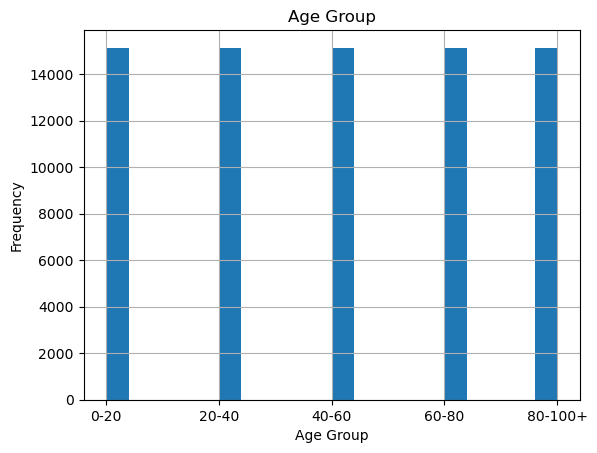

In [11]:
final_population_data['age_group'].hist(bins=20)
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Age Group')
plt.show()

Very interesting, unique counts are even across all age groups. This is due to the data in 'midyear_pop_5' being split across a 5 year age gap indicated by the columns 'starting_age' and 'ending_age' (see midyear_pop_5). This is an even range across all of the countries and years which means that the frequency of each country will be equal as 20 seperate age gaps. As a result, when we aggregate our ages into the 5 groups, it combines these groups evenly shown in the plot above

This is a violation of the assumption that the data may represent a continuous age distribution, instead shows our 5 year age groups.

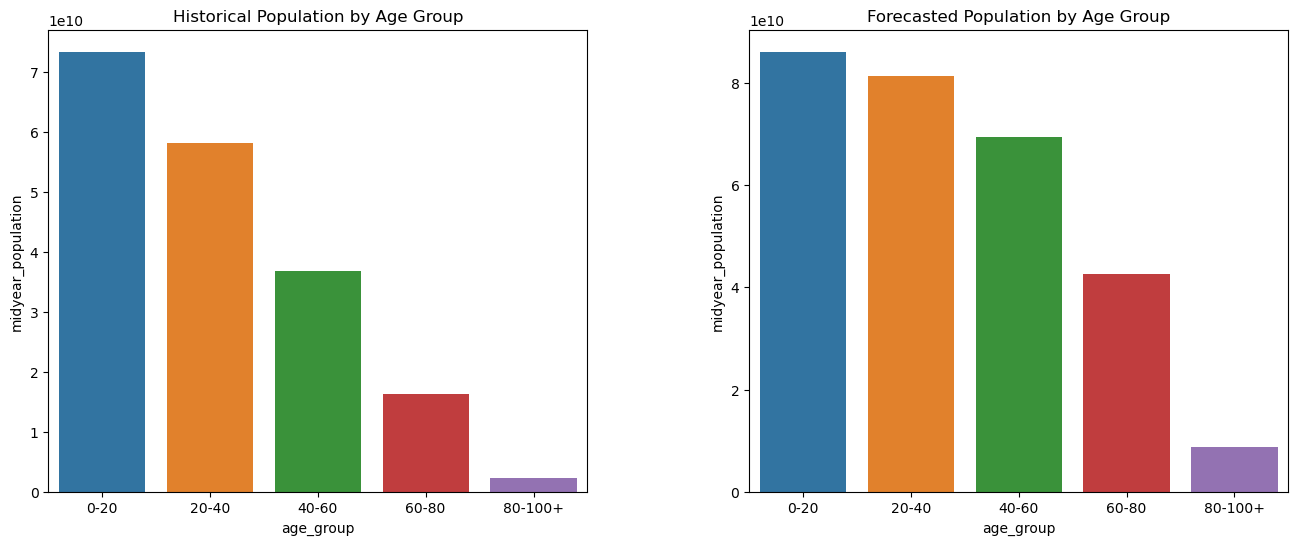

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# bar plot - historical population by age group
historical_age_pop = historical_all_data.groupby('age_group')['midyear_population'].sum().reset_index()

ax1.set_title("Historical Population by Age Group")
ax1.set_xlabel("Age Group")
ax1.set_ylabel("Midyear Population")
sns.barplot(data=historical_age_pop, x='age_group', y='midyear_population', ax=ax1)

# bar plot - forecasted population by age group
forecasted_age_pop = forecasted_all_data.groupby('age_group')['midyear_population'].sum().reset_index()

ax2.set_title("Forecasted Population by Age Group")
ax2.set_xlabel("Age Group")
ax2.set_ylabel("Midyear Population")
sns.barplot(data=forecasted_age_pop, x='age_group', y='midyear_population', ax=ax2)
plt.subplots_adjust(wspace=0.3)
plt.show()

The forecasted population distribution suggests a slight demographic shift with an aging global population. This can be seen from the increased population in the older age groups (60-80 and 80-100+) and a relative decrease in the youngest age group (0-20). The forecasted population in the working-age groups (20-40 and 40-60) implies that there will be a rise in these group populations, creating a more even spread of these age groups.

### Population Growth ###

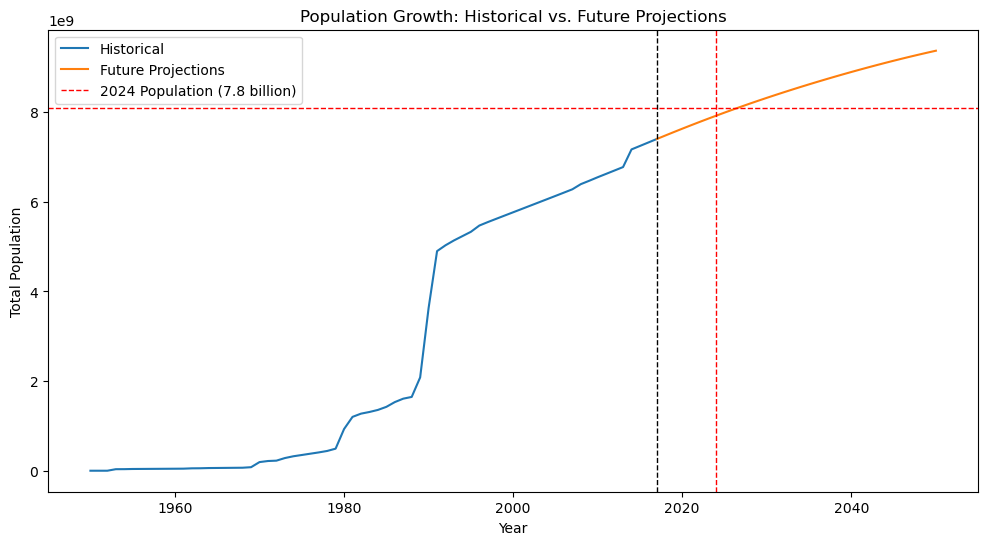

In [13]:
# population by year for historical data
historical_pop_by_year = historical_all_data.groupby('year')['midyear_population'].sum().reset_index()

# population by year for future projections
future_pop_by_year = forecasted_all_data.groupby('year')['midyear_population'].sum().reset_index()

# combined population by year - historical + future
combined_pop_by_year = pd.concat([historical_pop_by_year, future_pop_by_year])

plt.figure(figsize=(12, 6))
plt.plot(historical_pop_by_year['year'], historical_pop_by_year['midyear_population'], label='Historical')
plt.plot(future_pop_by_year['year'], future_pop_by_year['midyear_population'], label='Future Projections')
plt.axhline(y=8100000000, color='red', linestyle='--', linewidth=1, label='2024 Population (7.8 billion)')
plt.axvline(x=2017, color='black', linestyle='--', linewidth=1)
plt.axvline(x=2024, color='red', linestyle='--', linewidth=1)
plt.xlabel('Year')
plt.ylabel('Total Population')
plt.title('Population Growth: Historical vs. Future Projections')
plt.legend()
plt.show()

Black line indicates the end of the historical data and beginning of the forecasted data, at the year 2017
Red intersection indicates the current population of the world, 8.1 billion compared to the slightly lowered forecasted value

### Population Growth by Region and Year ###

Aggregating data by region and year to provide a "population data set" for both historical + population data. 
combined_pop_data -> region, year, midyear_population

In [14]:
# Aggregating data by region and year
region_year_pop_historical = historical_all_data.groupby(['region', 'year'])['midyear_population'].sum().reset_index()
region_year_pop_forecast = forecasted_all_data.groupby(['region', 'year'])['midyear_population'].sum().reset_index()

# pivot tables by age group and year + combining data
age_year_pop_historical = historical_all_data.pivot_table(index='age_group', columns='year', values='midyear_population', aggfunc='sum')
age_year_pop_forecast = forecasted_all_data.pivot_table(index='age_group', columns='year', values='midyear_population', aggfunc='sum')

combined_pop_data = pd.concat([region_year_pop_historical, region_year_pop_forecast])


# correlation matrix's data
print("\nCorrelation Matrix (Historical Data):")
corr_matrix_historical = historical_all_data[['midyear_population', 'midyear_population_male', 'midyear_population_female', 'population_density']].corr()
print(corr_matrix_historical)

print("\nCorrelation Matrix (Forecasted Data):")
corr_matrix_forecast = forecasted_all_data[['midyear_population', 'midyear_population_male', 'midyear_population_female', 'population_density']].corr()
print(corr_matrix_forecast)


Correlation Matrix (Historical Data):
                           midyear_population  midyear_population_male  \
midyear_population                   1.000000                 0.999755   
midyear_population_male              0.999755                 1.000000   
midyear_population_female            0.999718                 0.998947   
population_density                  -0.003872                -0.003380   

                           midyear_population_female  population_density  
midyear_population                          0.999718           -0.003872  
midyear_population_male                     0.998947           -0.003380  
midyear_population_female                   1.000000           -0.004398  
population_density                         -0.004398            1.000000  

Correlation Matrix (Forecasted Data):
                           midyear_population  midyear_population_male  \
midyear_population                   1.000000                 0.999382   
midyear_population_male     

Overall midyear population is strongly positively correlated with both the male and female midyear populations which is expected (this ensures data is aggregated correctly). This means that as the total population changes, the male and female populations tend to increase or decrease in a similar way.

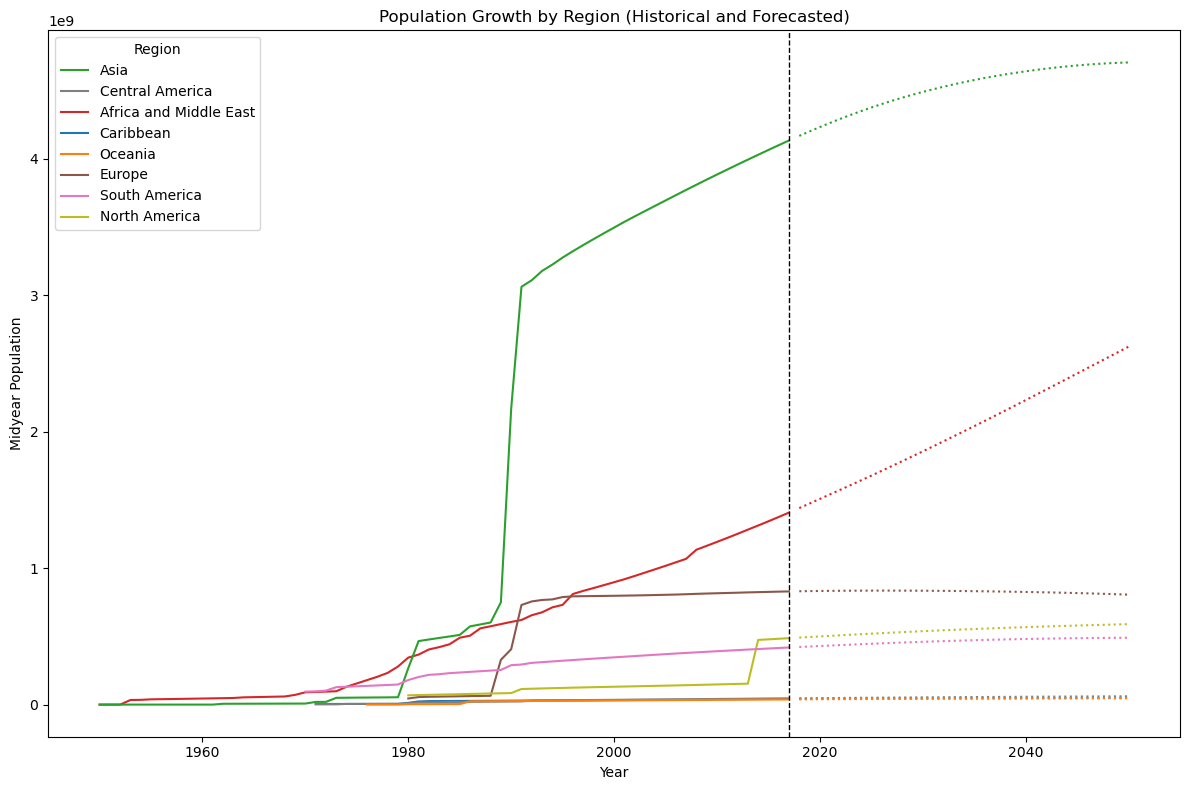

In [15]:
#mapping regions to colors
color_map = {
    'Africa and Middle East': 'tab:red',
    'Asia': 'tab:green',
    'Caribbean': 'tab:blue',
    'Central America': 'tab:gray',
    'Europe': 'tab:brown',
    'North America': 'tab:olive',
    'Oceania': 'tab:orange',
    'South America': 'tab:pink'
}

fig, ax = plt.subplots(figsize=(12, 8))

# historical data
for region in combined_pop_data['region'].unique():
    data = combined_pop_data[(combined_pop_data['region'] == region) & (combined_pop_data['year'] <= 2017)]
    region_color = color_map[region]
    ax.plot(data['year'], data['midyear_population'], label=region, linestyle='solid', color=region_color)

# forecasted data
for region in combined_pop_data['region'].unique():
    data = combined_pop_data[(combined_pop_data['region'] == region) & (combined_pop_data['year'] > 2017)]
    region_color = color_map[region]
    ax.plot(data['year'], data['midyear_population'], label='_nolegend_', linestyle=':', color=region_color)

# adding vertical line to separate historical and forecasted data
ax.axvline(x=2017, color='black', linestyle='--', linewidth=1)

ax.set_xlabel('Year')
ax.set_ylabel('Midyear Population')
ax.set_title('Population Growth by Region (Historical and Forecasted)')

handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]

ax.legend(unique_handles, unique_labels, title='Region', loc='upper left')

plt.tight_layout()
plt.show()

We can see that Asia had the highest population growth in the mid 1990's with a strong projection to keep growing. Followed by Africa and the Middle East, Central America and then North America in population growth. We observe a stagnant relationship with Oceania which could be misrepresented within this plot

### Population Density by Region and Year ###

In [16]:
# Aggregating population density by region and year
density_region_year_historical = historical_all_data.groupby(['region', 'year'])['population_density'].mean().reset_index()
density_region_year_forecast = forecasted_all_data.groupby(['region', 'year'])['population_density'].mean().reset_index()

#combined density for historical + forecasted
combined_density_data = pd.concat([density_region_year_historical, density_region_year_forecast])

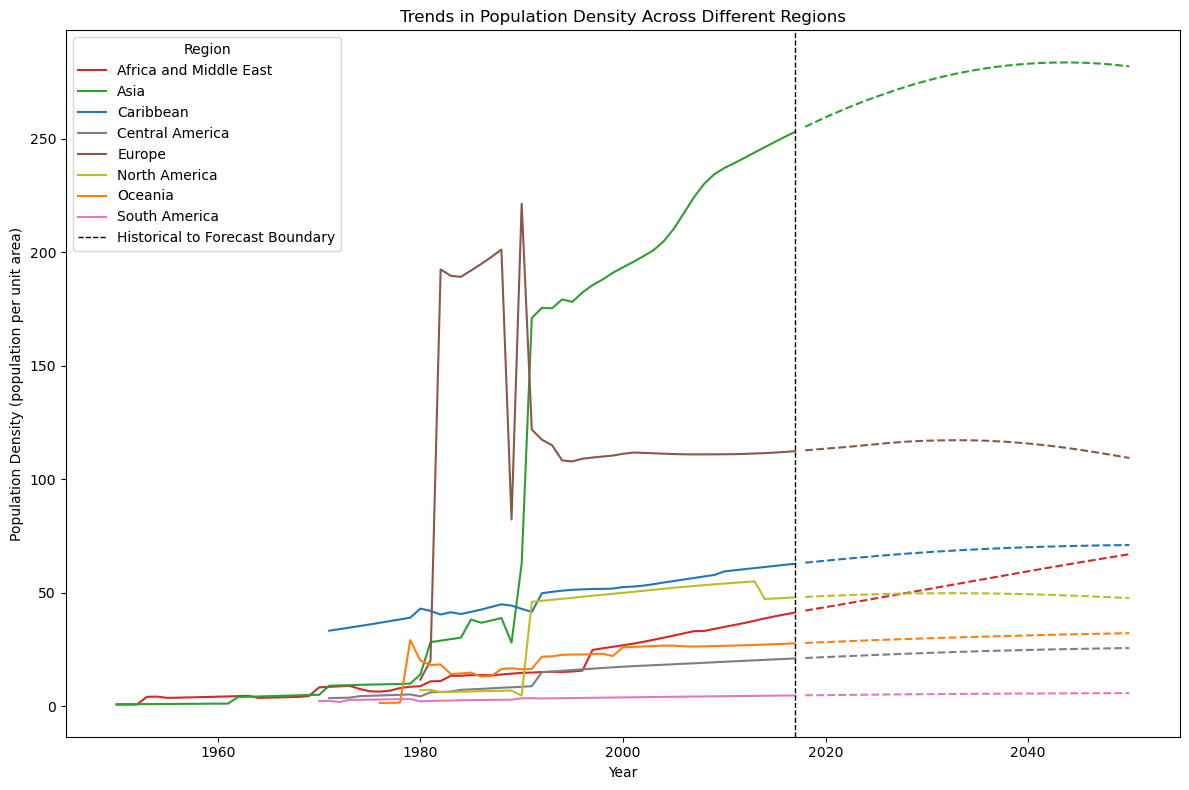

In [17]:
# population density over time
fig, ax = plt.subplots(figsize=(12, 8))
for region in combined_density_data['region'].unique():
    region_data_hist = combined_density_data[(combined_density_data['region'] == region) & (combined_density_data['year'] <= 2017)]
    region_data_fore = combined_density_data[(combined_density_data['region'] == region) & (combined_density_data['year'] > 2017)]
    ax.plot(region_data_hist['year'], region_data_hist['population_density'], label=region, linestyle='-', color=color_map.get(region, 'gray'))
    ax.plot(region_data_fore['year'], region_data_fore['population_density'], label='_nolegend_', linestyle='--', color=color_map.get(region, 'gray'))

ax.axvline(x=2017, color='black', linestyle='--', linewidth=1, label='Historical to Forecast Boundary')
ax.set_xlabel('Year')
ax.set_ylabel('Population Density (population per unit area)')
ax.set_title('Trends in Population Density Across Different Regions')
ax.legend(title='Region', loc='upper left')
plt.tight_layout()
plt.show()

We can observe that 'Asia' has the highest population density throughout the entire period, followed by 'Europe'. These regions have significantly higher densities compared to other regions. 'Europe' and 'Asia' shows a rapid increase in population density over time with a steeper slope compared to other regions. This suggests that these regions are experiencing the fastest growth in population density.
'South America' and 'Oceania' have the lowest population densities among all regions and the rest of the regions seem to observe a relative steady increase/decrease within the population density. The forecasted data suggests that the population density will continue to increase across all regions, with 'Asia' and 'Africa and the Middle East' experiencing the most significant growth.

## Exploratory Analysis of Life Expectancy, Growth and Mortality Data ##

### Life Expectancy ###

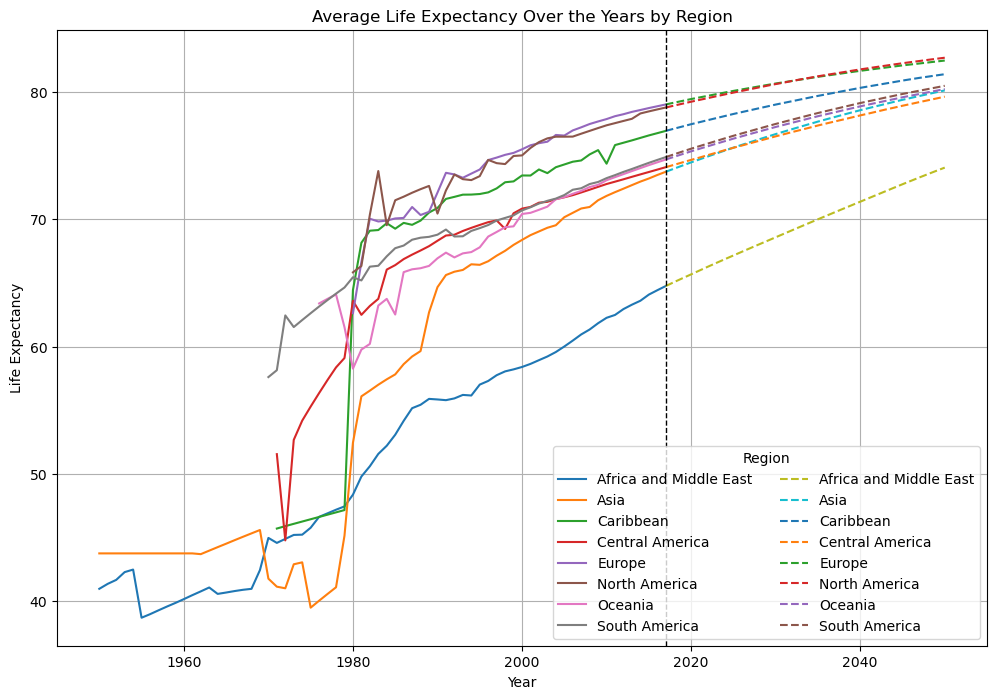

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
life_hist = historical_all_data.groupby(['region', 'year'])['life_expectancy'].mean().unstack(level=0)
life_hist.plot(ax=ax)
life_fore = forecasted_all_data.groupby(['region', 'year'])['life_expectancy'].mean().unstack(level=0)
life_fore.plot(ax=ax, style='--')

ax.set_title('Average Life Expectancy Over the Years by Region')
ax.set_xlabel('Year')
ax.set_ylabel('Life Expectancy')
ax.legend(title='Region',ncol=2)
ax.axvline(x=2017, color='black', linestyle='--', linewidth=1, label='Historical to Forecast Boundary')
ax.grid(True)

When looking at the Life Expectancy of different Regions over time we see that the entire world as whole saw a major rise in life expectancy starting in the 1970s. This continued to go on with a gradual increase however it seems that we are seeing a diminishing growth rate in life expectancy which the forecasted data seems to agree with. It is also worth noting that though the Africa and Middle East region appears to be growing at a similar rate as the rest of the Regions we can still see a disparity of about 10 years of life expectancy. 

### Growth ###

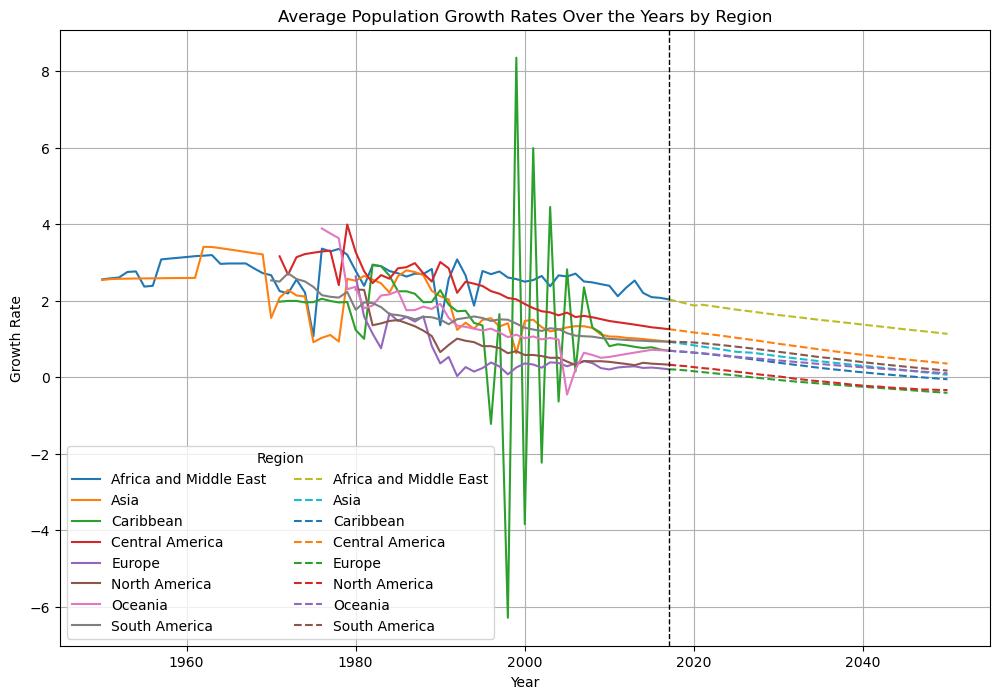

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
historical_all_data.groupby(['region', 'year'])['growth_rate'].mean().unstack(level=0).plot(ax=ax)
forecasted_all_data.groupby(['region', 'year'])['growth_rate'].mean().unstack(level=0).plot(ax=ax, style='--')

ax.set_title('Average Population Growth Rates Over the Years by Region')
ax.set_xlabel('Year')
ax.set_ylabel('Growth Rate')
ax.legend(title='Region',ncol=2)
ax.axvline(x=2017, color='black', linestyle='--', linewidth=1, label='Historical to Forecast Boundary')
ax.grid(True)

Reviewing the population growth we can see the Caribbean's growth rate was extremely volatile from the mid 1990's to the mid 2000's. We decided to further investigate this first by looking at sources of growth are impacting the Caribbean region so largely. We can also see that we are projected to continue to have our growth rate decrease with regions such as North America and Europe expecting a decreasing rate of population.

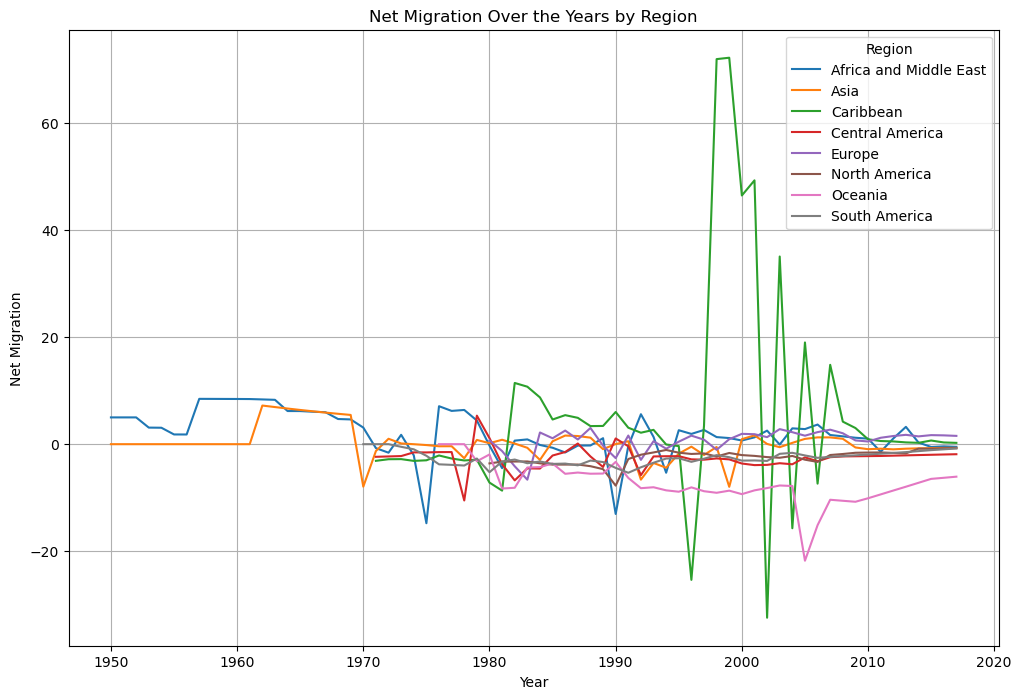

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))

historical_all_data.groupby(['region', 'year'])['net_migration'].mean().unstack(level=0).plot(ax=ax)

ax.set_title('Net Migration Over the Years by Region')
ax.set_xlabel('Year')
ax.set_ylabel('Net Migration')
ax.legend(title='Region')
ax.grid(True)

It appears that we are seeing a massive change in the Caribbean's Net Migration Rates which is showing the same volatile behavior that we saw in the previous graph. Now we'll dive deeper and investigate if it is only a couple nations that are causing these sharp changes.

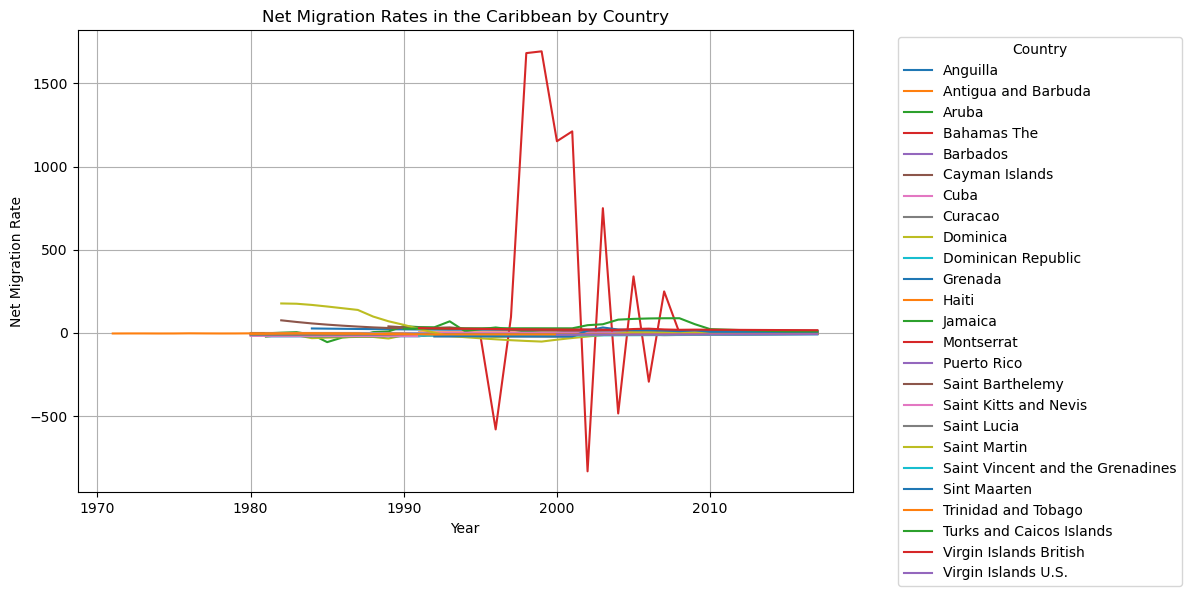

In [21]:
# Investigating Net Migration in the Caribbean
caribbean_migration = historical_all_data[historical_all_data['region'] == 'Caribbean']
carib_piv = pd.pivot_table(data=caribbean_migration,values='net_migration',index='year',columns='country_name',aggfunc='mean')

carib_piv.plot(figsize=(10, 6))
plt.title('Net Migration Rates in the Caribbean by Country')
plt.xlabel('Year')
plt.ylabel('Net Migration Rate')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

We now can see that it was the island nation of Montserrat that seemed to be responsible for the massive changes in the average net migration rate in the region. Doing some further investigation we found that in 1995 the volcano home to Montserrat errupted resulting in large portions of the population to leave. The volcano still remained active for the next 10 years after inhabitants moved back which is shown in the sharp changes in our line plot.

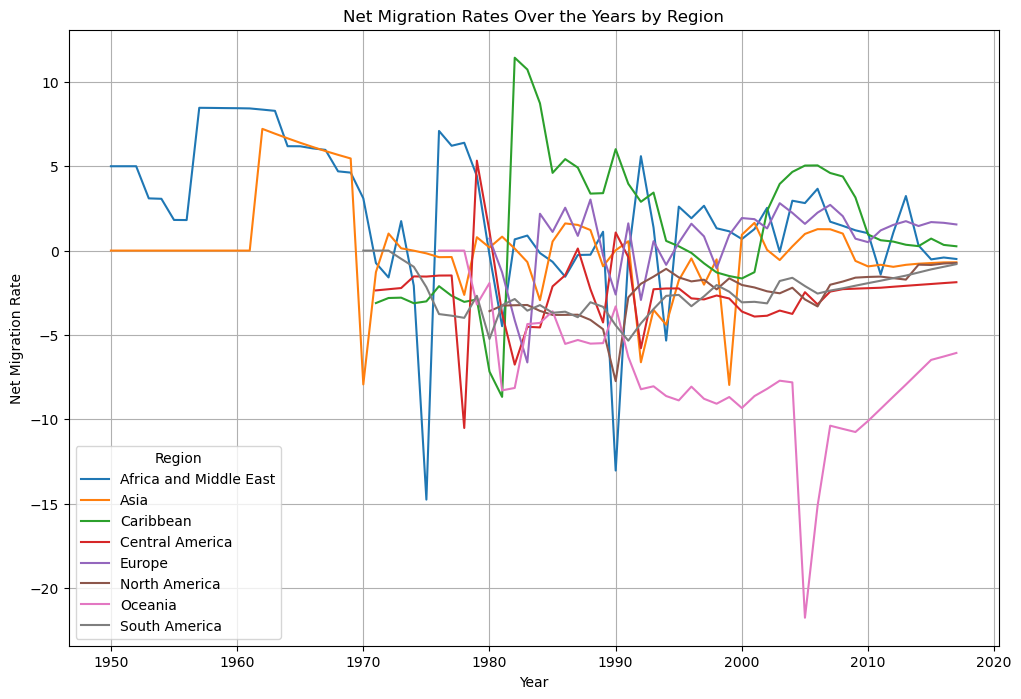

In [22]:
no_montserrat = historical_all_data[historical_all_data['country_name'] != 'Montserrat']


fig, ax = plt.subplots(figsize=(12, 8))
no_montserrat.groupby(['region','year'])['net_migration'].mean().unstack(level=0).plot(ax=ax)

ax.set_title('Net Migration Rates Over the Years by Region')
ax.set_xlabel('Year')
ax.set_ylabel('Net Migration Rate')
ax.legend(title='Region')
ax.grid(True)

Since the skewedness of our data was due to the country of Montseratt we decided to take it out of our datset to view how migration rates and growth rates now look. We can also see that there were migration rates as low as -14 people per 1,000 population in Africa and the Middle East in the 1970's. The other regions look to be ocelating of a net migration rate -10 to 10. Oceania appeared to have had a high rate of people leaving the region startng in the 1990's and dropping even further in the 2000's. Overall the dataset shows a lot of variance with the forecasts predicting no big migration changes from 2017 moving foreward.

### Net Migration ###

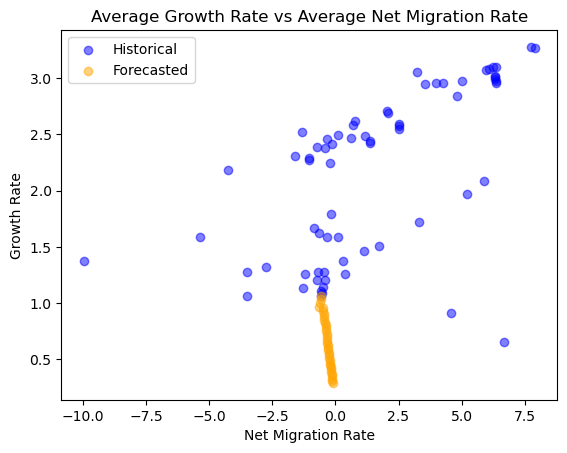

In [23]:
plt.scatter(x='net_migration', y='growth_rate', data = historical_all_data.groupby(['year'])[['growth_rate', 'net_migration']].mean()
            , color='blue', label='Historical', alpha=0.5)
plt.scatter(x='net_migration', y='growth_rate', data = forecasted_all_data.groupby(['year'])[['growth_rate', 'net_migration']].mean()
            , color='orange', label='Forecasted', alpha=0.5)
plt.title('Average Growth Rate vs Average Net Migration Rate')
plt.xlabel('Net Migration Rate')
plt.ylabel('Growth Rate')
plt.legend()

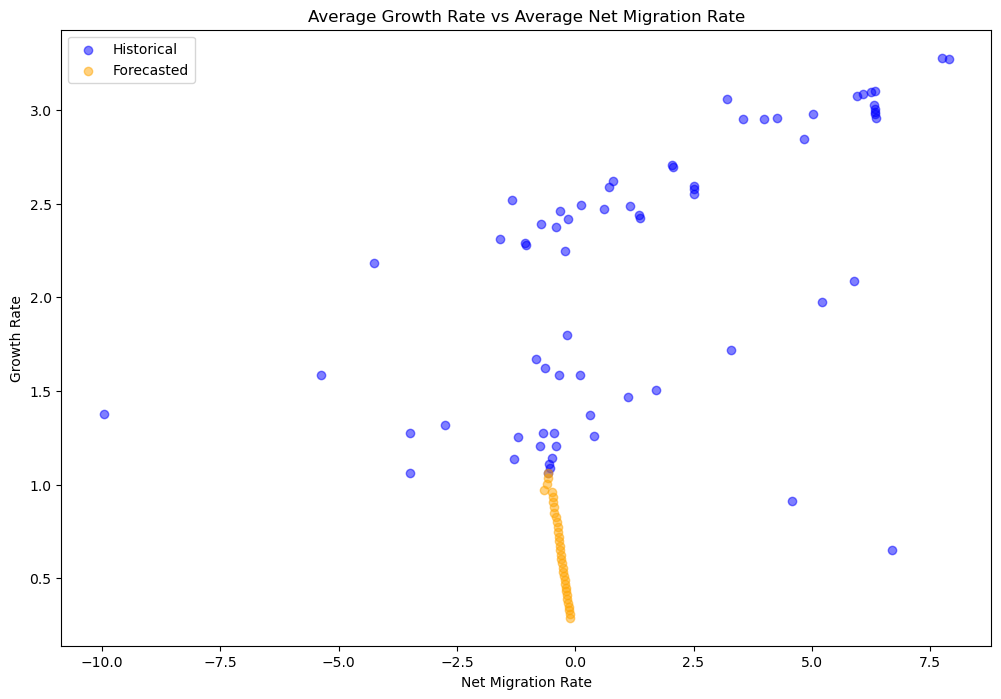

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))

historical_data_mean = historical_all_data.groupby(['year'])[['growth_rate', 'net_migration']].mean()
ax.scatter(x=historical_data_mean['net_migration'], y=historical_data_mean['growth_rate'],
           color='blue', label='Historical', alpha=0.5)

forecasted_data_mean = forecasted_all_data.groupby(['year'])[['growth_rate', 'net_migration']].mean()
ax.scatter(x=forecasted_data_mean['net_migration'], y=forecasted_data_mean['growth_rate'],
           color='orange', label='Forecasted', alpha=0.5)

ax.set_title('Average Growth Rate vs Average Net Migration Rate')
ax.set_xlabel('Net Migration Rate')
ax.set_ylabel('Growth Rate')
ax.legend()

When looking at if the average Net Migration Rate impacts over average growth rates on the world as a whole we rough correlation at least when Net Migration Rates. However there is still noteable noise in the data and theses aggregations. The dataset also seems to predict that the Net Migration Rate will be at a net zero with population growth rates still increasing.

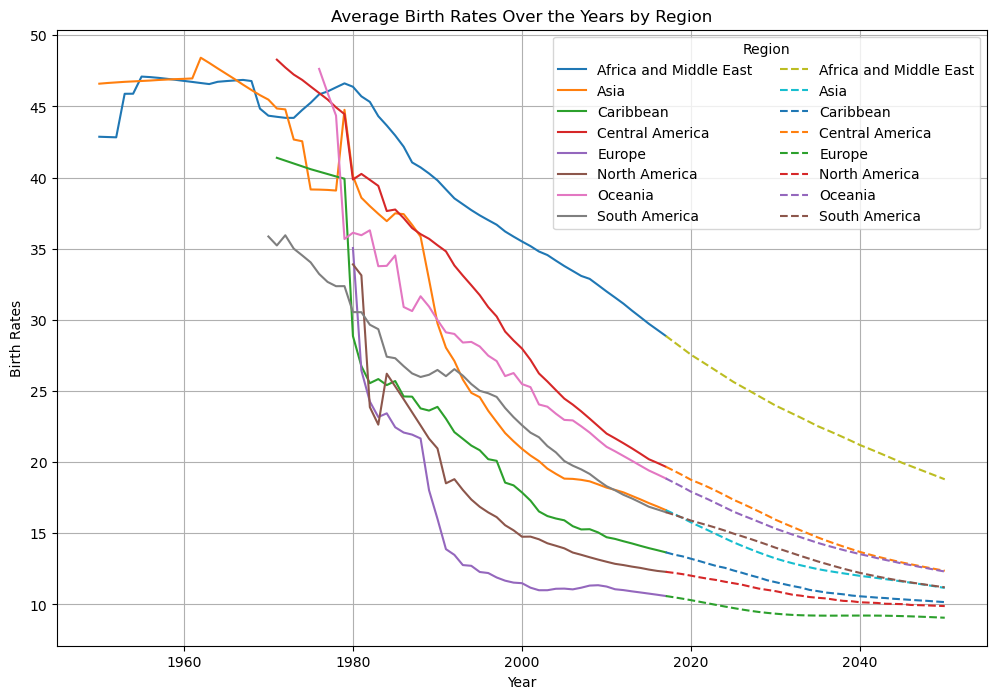

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))

historical_all_data.groupby(['region', 'year'])['crude_birth_rate'].mean().unstack(level=0).plot(ax=ax)
forecasted_all_data.groupby(['region', 'year'])['crude_birth_rate'].mean().unstack(level=0).plot(ax=ax, style='--')

ax.set_title('Average Birth Rates Over the Years by Region')
ax.set_xlabel('Year')
ax.set_ylabel('Birth Rates')
plt.legend(title='Region', ncol=2)
plt.grid(True)

The birth rate variable which looks at the number of births per 1000 population has appeared to been declining since the start of our dataset. We can also observe that Africa and the Middle East have higher birth rates since the 1980's. With a consistent gap of about 10 births this carries on into the forecasts.

### Mortality ###

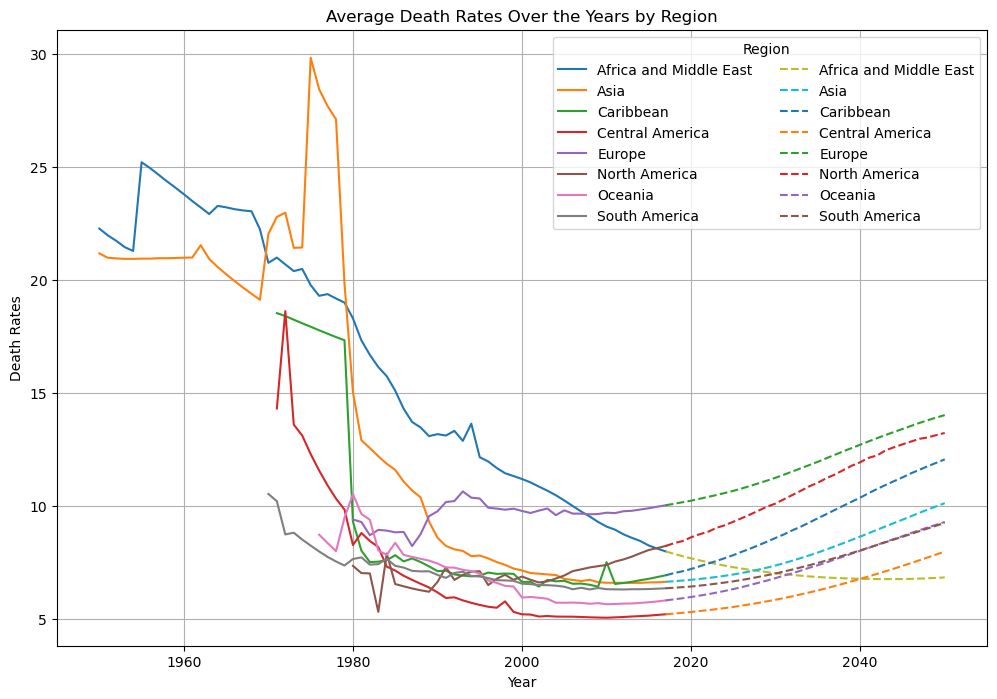

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))

historical_all_data.groupby(['region', 'year'])['crude_death_rate'].mean().unstack(level=0).plot(ax=ax)
forecasted_all_data.groupby(['region', 'year'])['crude_death_rate'].mean().unstack(level=0).plot(ax=ax, style='--')

ax.set_title('Average Death Rates Over the Years by Region')
ax.set_xlabel('Year')
ax.set_ylabel('Death Rates')
plt.legend(title='Region', ncol=2)
plt.grid(True)

Observing the average Death Rates across regions over the years we see that through the 1960's into the 1980's the death rate for Asia and Africa and the Middle east were exceptionally high with up to 30 deaths per 1,000 population. We can speculate that conflicts such as the Vietnam War that were taking place at the time were responsible for such high death rates. We can also see that Europe has been having consistently higher death rates than most other regions since around the 1990's.

This is also one of the more interesting predictions by the dataset as it forecasts an increase in the average crude death rates over almost all regions except for Africa and the Middle East, which is forecasted to continue its downward trend.

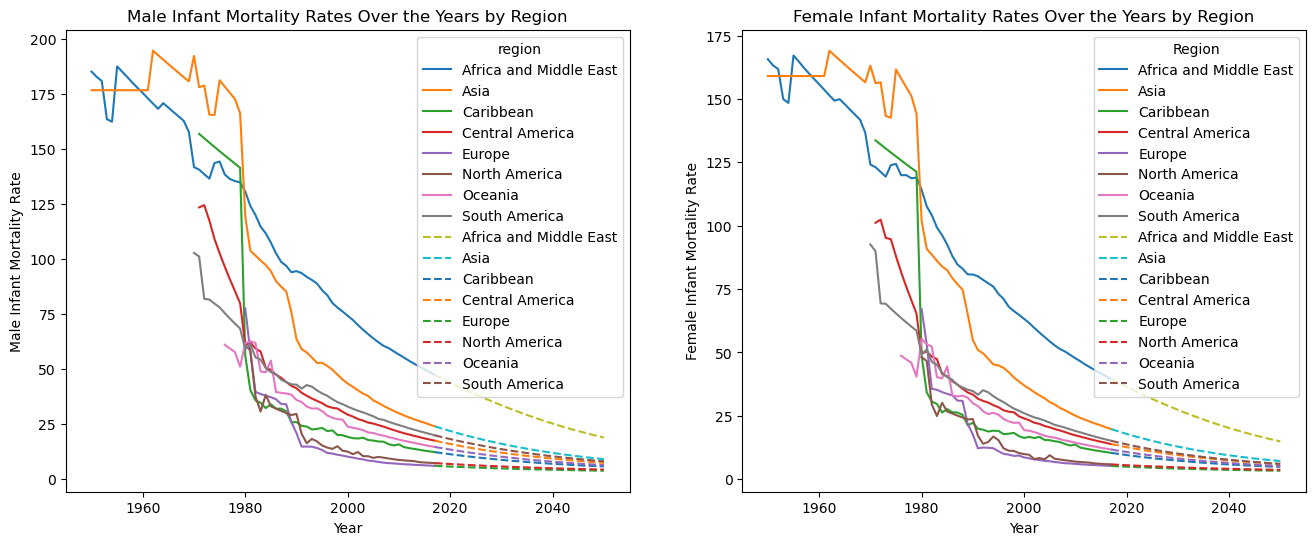

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

historical_all_data.groupby(['region', 'year'])['infant_mortality_male'].mean().unstack(level=0).plot(ax=ax1)
forecasted_all_data.groupby(['region', 'year'])['infant_mortality_male'].mean().unstack(level=0).plot(ax=ax1, style='--')

historical_all_data.groupby(['region', 'year'])['infant_mortality_female'].mean().unstack(level=0).plot(ax=ax2)
forecasted_all_data.groupby(['region', 'year'])['infant_mortality_female'].mean().unstack(level=0).plot(ax=ax2, style='--')


ax1.set_title("Male Infant Mortality Rates Over the Years by Region")
ax1.set_xlabel("Year")
ax1.set_ylabel("Male Infant Mortality Rate")
plt.legend(title='Region', ncol=1)

ax2.set_title("Female Infant Mortality Rates Over the Years by Region")
ax2.set_xlabel("Year")
ax2.set_ylabel("Female Infant Mortality Rate")
plt.legend(title='Region', ncol=1)



The data also consisted of infant mortality rates amoung male and female infants. We can observe that both sexes follow a similar trend with infant though the infant mortality for men was appeared to be higher by about 25 more infant deaths per 1,000 population. This disparity seems to only be prominent before the 1980's even though they both begin with initally high rates across all regions. The disparity between the region of Africa and the Middle East and the rest of the regions in the world persists.

### Fertility ###

Text(0, 0.5, 'Fertility Rate')

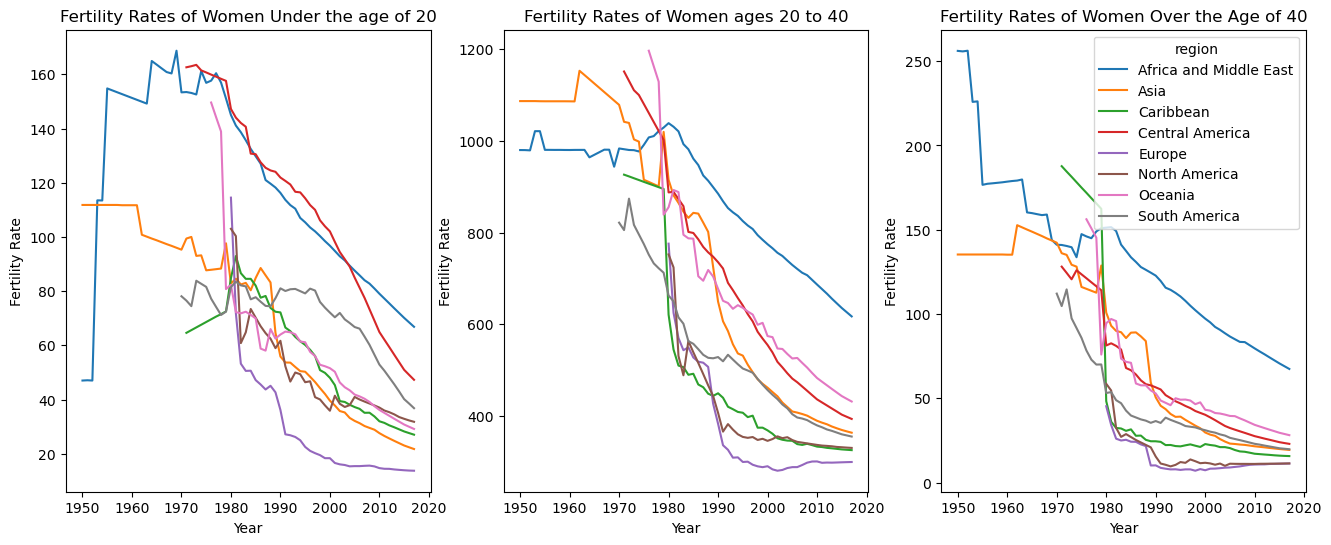

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

historical_all_data.groupby(['region', 'year'])['fertility_rate_Under_20'].mean().unstack(level=0).plot(ax=ax1)
ax1.set_title("Fertility Rates of Women Under the age of 20")
ax1.set_xlabel("Year")
ax1.set_ylabel("Fertility Rate")
ax1.legend().set_visible(False)

historical_all_data.groupby(['region', 'year'])['fertility_rate_20_to_40'].mean().unstack(level=0).plot(ax=ax2)
ax2.set_title("Fertility Rates of Women ages 20 to 40")
ax2.set_xlabel("Year")
ax2.set_ylabel("Fertility Rate")
ax2.legend().set_visible(False)

historical_all_data.groupby(['region', 'year'])['fertility_rate_40+'].mean().unstack(level=0).plot(ax=ax3)
ax3.set_title("Fertility Rates of Women Over the Age of 40")
ax3.set_xlabel("Year")
ax3.set_ylabel("Fertility Rate")

We see here that though Women in the age range of 20 to 40 have higher fertility rates they still are following this downward trend over time. When looking at the regions we see that across all age groups Africa and the Middle East have the highest Fertility Rates and Europe has the lowest.

## Exploratory Analysis of Combined Population + Life Expectancy, Growth and Mortality Data ##

### Fertility Rate vs. Percentage of Population by Age Group ###

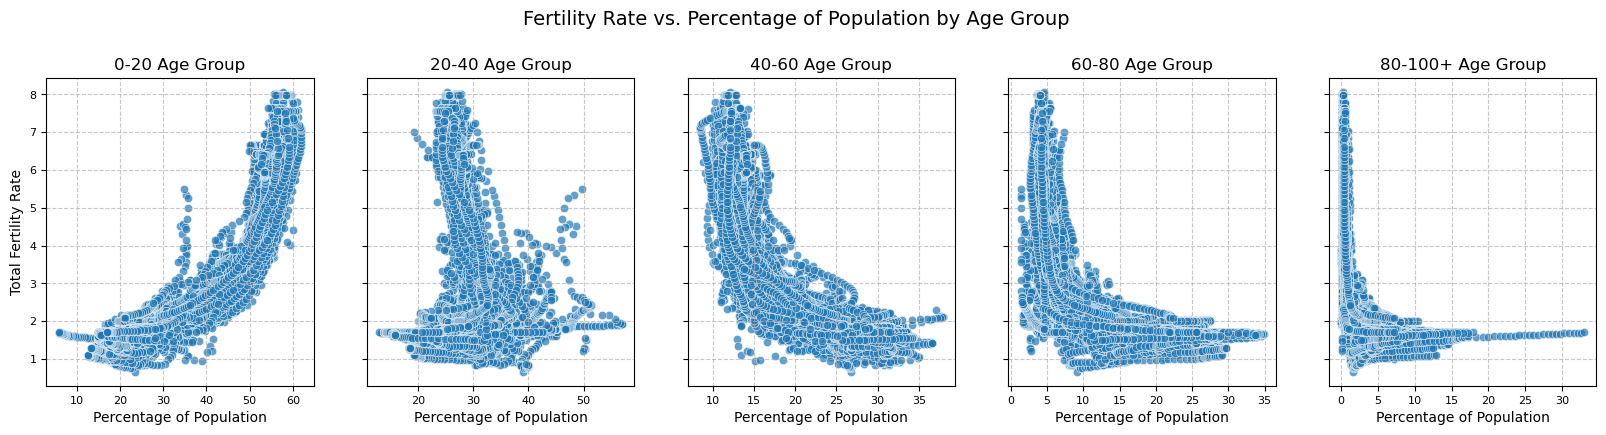

In [29]:
age_groups = ['0-20', '20-40', '40-60', '60-80', '80-100+']

fig, axes = plt.subplots(1, len(age_groups), figsize=(20, 4), sharey=True)

for j, age_group in enumerate(age_groups):
    # percentage of population in each age group
    merged_all_data[f'pct_{age_group}'] = merged_all_data['midyear_population'] / merged_all_data.groupby(['country_name', 'year'])['midyear_population'].transform('sum') * 100
    
    sns.scatterplot(data=merged_all_data[merged_all_data['age_group'] == age_group], x=f'pct_{age_group}', y='total_fertility_rate', alpha=0.7, ax=axes[j])
    
    axes[j].set_title(f'{age_group} Age Group', fontsize=12)
    axes[j].set_xlabel(f'Percentage of Population', fontsize=10)
    if j == 0:
        axes[j].set_ylabel('Total Fertility Rate', fontsize=10)
    axes[j].grid(True, linestyle='--', alpha=0.7)
    axes[j].tick_params(labelsize=8)

plt.subplots_adjust(wspace=0.2)
fig.suptitle('Fertility Rate vs. Percentage of Population by Age Group', fontsize=14, y=1.05)
plt.show()

The 0-20 age group shows a relatively narrow range of fertility rates concentrated around lower values likely representing populations with low birth rates among children and teenagers. The 20-40 age group exhibits a wider range of fertility rates with a dense concentration of points indicating higher fertility rates as expected since most people have kids around this age. The 40-60 age group shows a similar pattern to the 20-40 group but shows the gradual decline in fertility with age. This pattern continues with the 60+ age groups.

Overall, these plots highlight the strong relationship between age and fertility, with fertility rates peaking in the 20-40 age group and declining sharply in older age groups. The patterns observed in these plots align with the expected demographic trends in populations with varying age distributions.

### Infant Mortality vs. Percentage of Population by Age Group ###

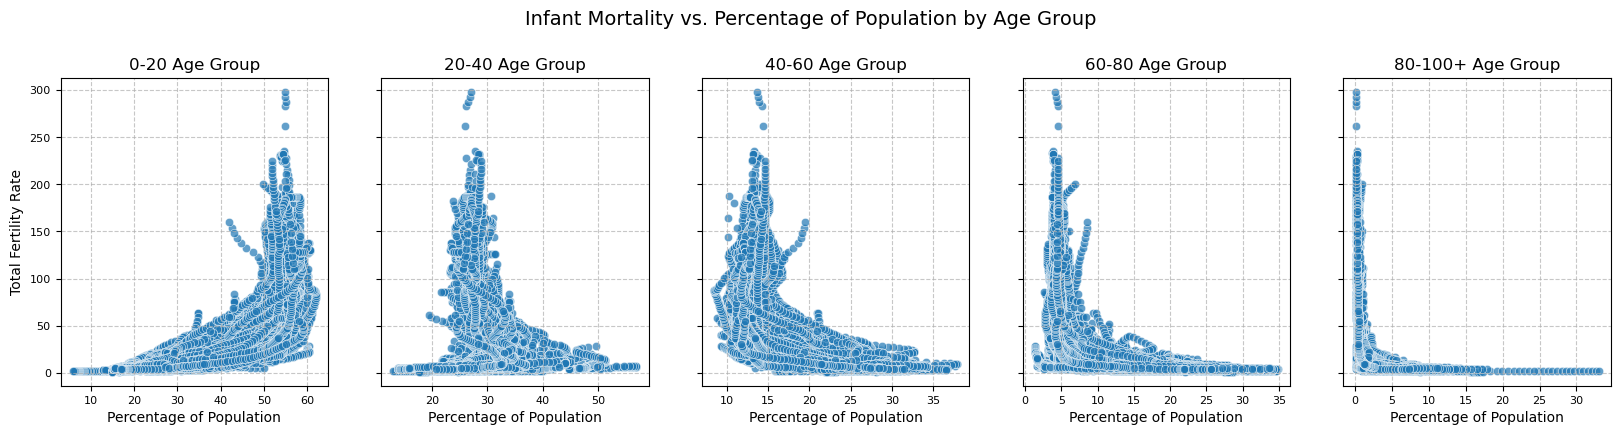

In [30]:
age_groups = ['0-20', '20-40', '40-60', '60-80', '80-100+']

fig, axes = plt.subplots(1, len(age_groups), figsize=(20, 4), sharey=True)

for j, age_group in enumerate(age_groups):
    # percentage of population in each age group
    merged_all_data[f'pct_{age_group}'] = merged_all_data['midyear_population'] / merged_all_data.groupby(['country_name', 'year'])['midyear_population'].transform('sum') * 100
    
    sns.scatterplot(data=merged_all_data[merged_all_data['age_group'] == age_group], x=f'pct_{age_group}', y='infant_mortality', alpha=0.7, ax=axes[j])
    
    axes[j].set_title(f'{age_group} Age Group', fontsize=12)
    axes[j].set_xlabel(f'Percentage of Population', fontsize=10)
    if j == 0:
        axes[j].set_ylabel('Total Fertility Rate', fontsize=10)
    axes[j].grid(True, linestyle='--', alpha=0.7)
    axes[j].tick_params(labelsize=8)

plt.subplots_adjust(wspace=0.2)
fig.suptitle('Infant Mortality vs. Percentage of Population by Age Group', fontsize=14, y=1.05)
plt.show()

### Net Migration and Population Density by Region ###

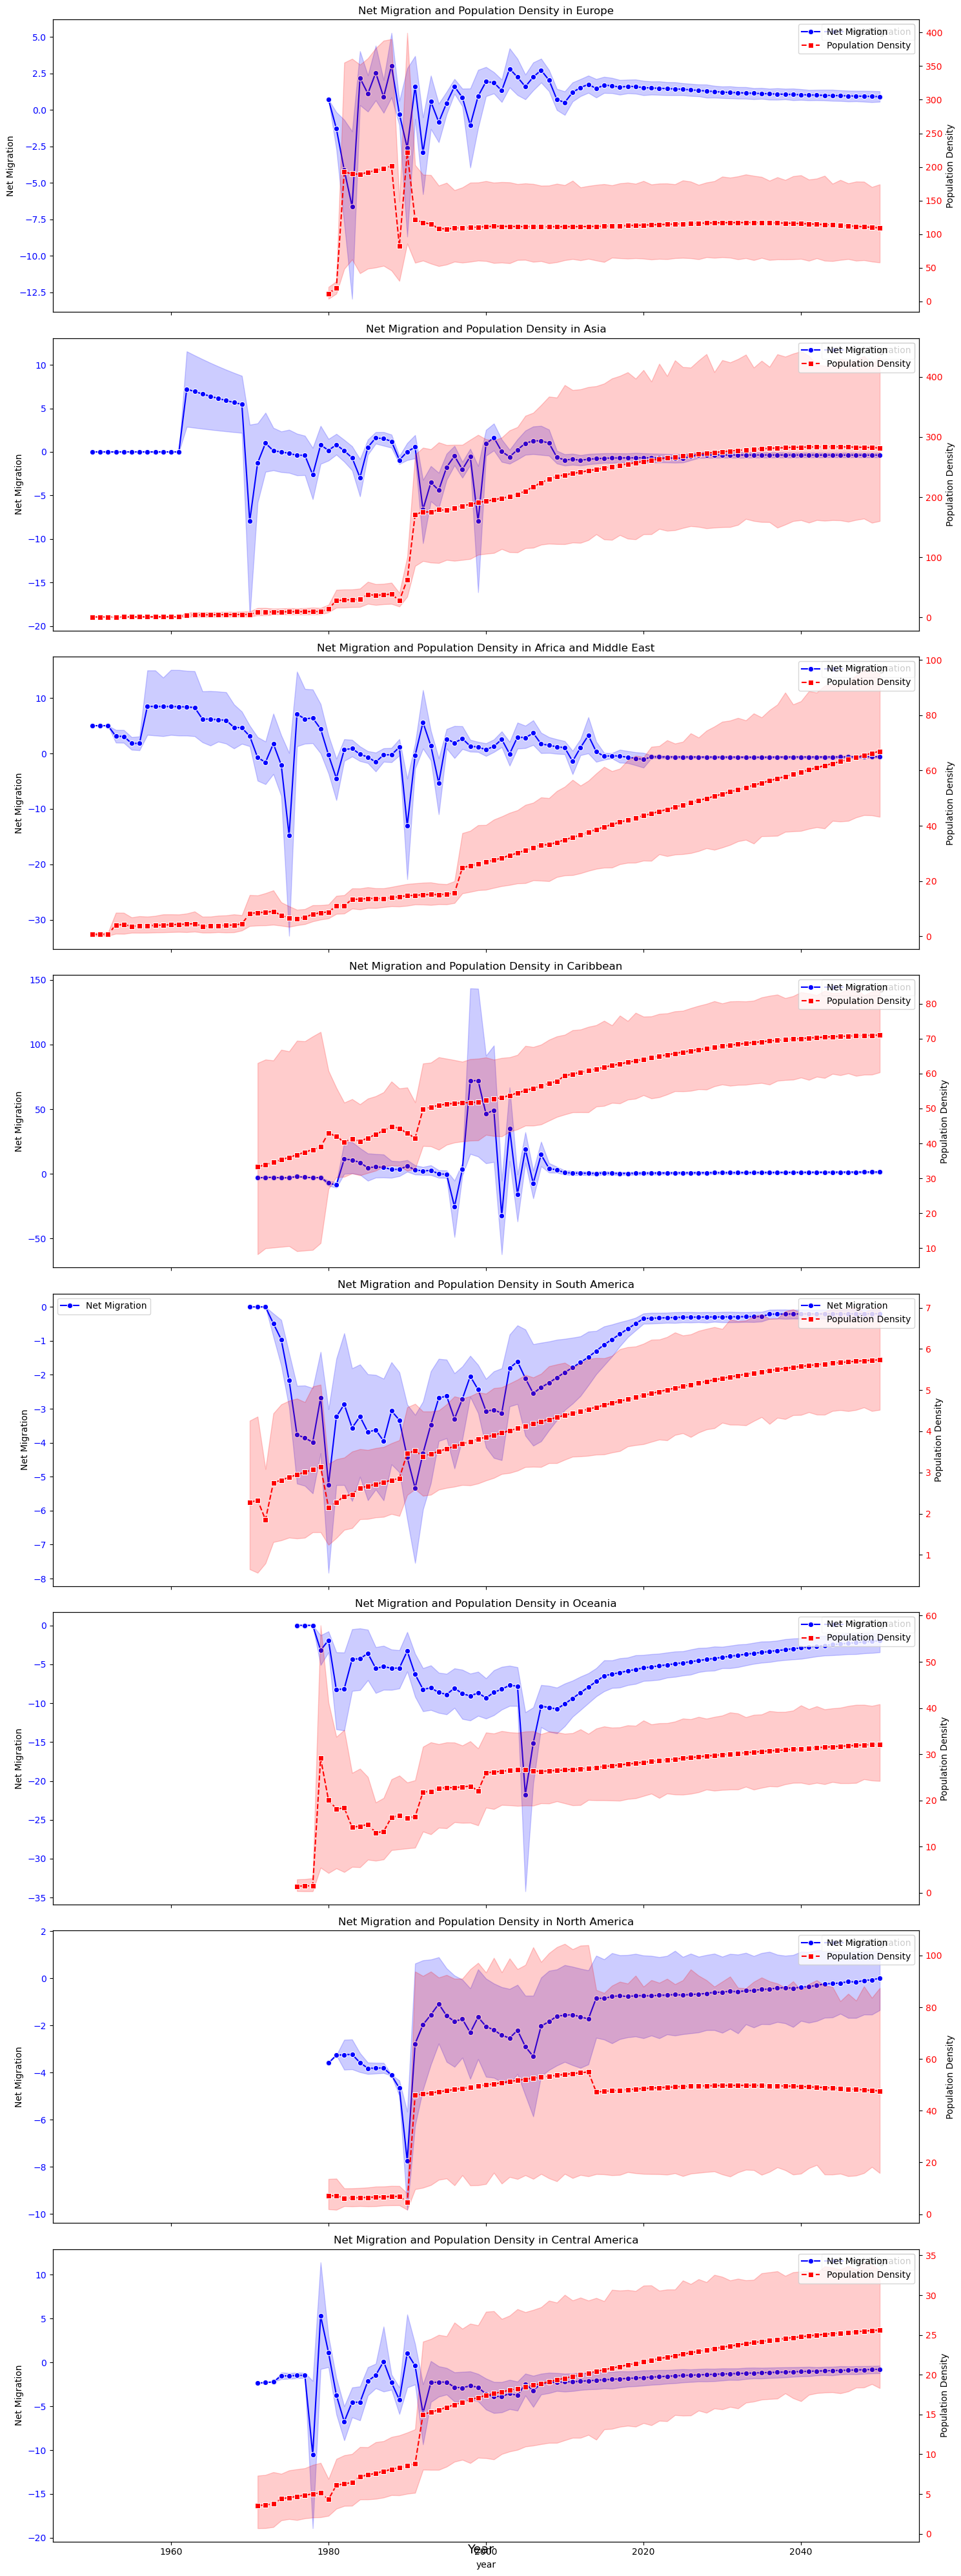

In [31]:
regions = merged_all_data['region'].unique()  # Extract unique regions

# Set up the subplot grid with one row per region
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(15, 5 * len(regions)), sharex=True)

# Ensure 'axes' is an array, even if there is only one plot
if len(regions) == 1:
    axes = [axes]

# Iterate over each region and create a plot
for ax, region in zip(axes, regions):
    region_data = merged_all_data[merged_all_data['region'] == region]

        # First y-axis for Net Migration
    sns.lineplot(data=region_data, x='year', y='net_migration', ax=ax, color='blue', marker="o", label='Net Migration')
    ax.set_title(f'Net Migration and Population Density in {region}')
    ax.set_ylabel('Net Migration')
    ax.tick_params(axis='y', labelcolor='blue')
        
        # Create a second y-axis for Population Density
    ax2 = ax.twinx()
    sns.lineplot(data=region_data, x='year', y='population_density', ax=ax2, color='red', linestyle='--', marker="s", label='Population Density')
    ax2.set_ylabel('Population Density')
    ax2.tick_params(axis='y', labelcolor='red')

        # Managing legends
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
    
fig.tight_layout()
fig.text(0.5, 0.01, 'Year', ha='center', fontsize=14)
plt.show()

This subplot array features the Net Migration rates (blue line) and Population Density (red line) plotted by each region. Overall as a general overview, it seems that the data is too broad and doesn't provide much correlation or insight due to the amount of countries being aggregated into each region. This provides such a wide range of values consititing of each countries population density that it doesn't give much relation to the net migration of the overall region. This being said however there are a few observable trends such as in the mid 1990's in North America when net migration dips and then soars back up at the same time population density shoots up. An opposite trend can be seen in South America in the 1980's when a sharp decline in Net Migration rates happens at the same time as a decline in the population density.

## Conclusion ##

Across almost all variables such as growth, death, birth, and fertility rates, we see a clear downward trend in the past 70 years. The exceptions to this would be our life expectancy and net migration rate variables where we see a clear upward trend for life expectancy, while net migration rates have a (albiet highly volatile) ocelating rate around zero. The forecasts of our features do for the most part continue the trend that they were going, however they are implimenting little to no variability in their projections. The main takeaway from looking at any disparities within the regions would be that Africa and the Middle East have had consistently higher mortality and birth rates while having considerably lower life expectancy than the rest of the other regions. In regards to population growth rates and immigration, we see some correlation which is to be expected however the data still shows some large variance. Additionally the forecast for net migrations appear to be close to zero and therefore imply that it will have no impact on growth rates as they are still increasing in the forecasts.

When looking at our population data, we observe common trends that one would expect such as a general upwards trend of growth and density in most regions however due to the unique counts of our 'age_group' variable, we weren't able to extract much meaningful data between each age group other than their percentage of population by group. This leads back to a choice made in the data cleaning steps to utilize the 'midyear_population_5yr_age_sex' dataset which already had aggregations of the ages into groups of 5 years. We had access to a larger, more faceted dataset called 'midyear_population_age_sex' which had population numbers for each age from 0 - 100 however due to this datatset being simply massive, we decided against using it for computational reasons. Reflecting on this project, it becomes apparent that utilizing the larger dataset might have uncovered intricate patterns within age demographics. Performing aggregations, similar to 'age_group' on the population data, on the larger dataset might reveal additional relationships and provide a deeper understanding of demographic shifts.

Overall, our research successfully addressed the initial questions, revealing how various human development indexes like fertility, birth, and mortality rates differ across countries over time. These insights contribute valuable perspectives to the study of global demographic trends.
